# Modelando os tópicos da RBEF ao longo do tempo usando Latent Dirichlet Allocation 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [105]:
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gensim.models import CoherenceModel

from utils.pre_processing import tokenizer, html_to_text
from utils.model import add_bigram, create_dictionary, create_corpus
from utils.model import ModelLDA, calc_coherence
from utils.plots import plot_frequent_words, plot_wordcloud

## Leitura do banco de dados

In [3]:
df = pd.read_feather('scielo_dataset.feather')

## Tokenizaçao e Lemmetização

In [4]:
with Pool() as pool:
    # limpa o html dos textos.
    textos = list(tqdm(pool.imap(html_to_text, df['texto_html']), total=len(df)))
    
    # tokeniza e lemmetiza os textos.
    documentos = list(tqdm(pool.imap(tokenizer, textos), total=len(textos)))

  0%|          | 0/1664 [00:00<?, ?it/s]

  0%|          | 0/1664 [00:00<?, ?it/s]

## Bigram e criação do dicionário

In [5]:
add_bigram(documentos, min_count=15)

In [6]:
dicionario_sem_filtro = create_dictionary(documentos, filtrar=False)
dicionario = create_dictionary(documentos, n_abaixo=30, n_acima=0.5)

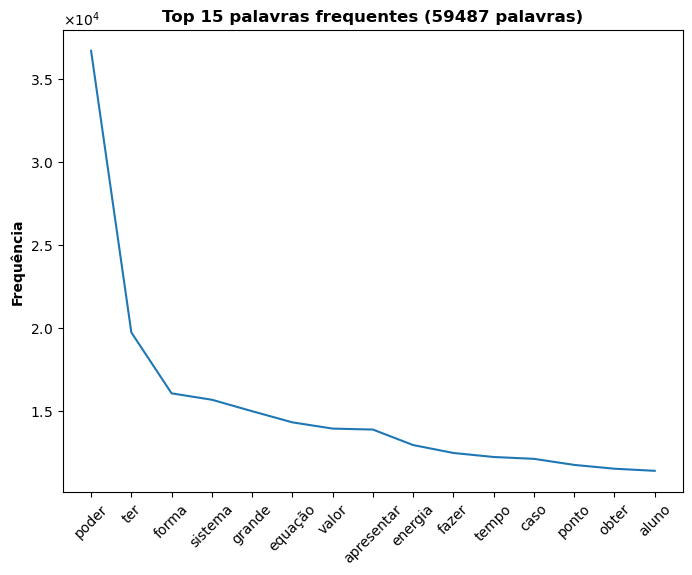

In [7]:
plot_frequent_words(dicionario_sem_filtro, filename='dicionario_completo.png')

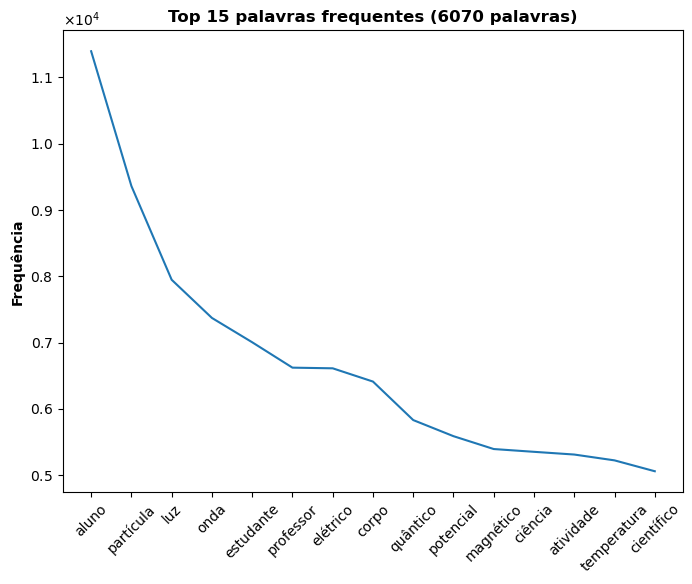

In [8]:
plot_frequent_words(dicionario, filename='dicionario_filtro.png')

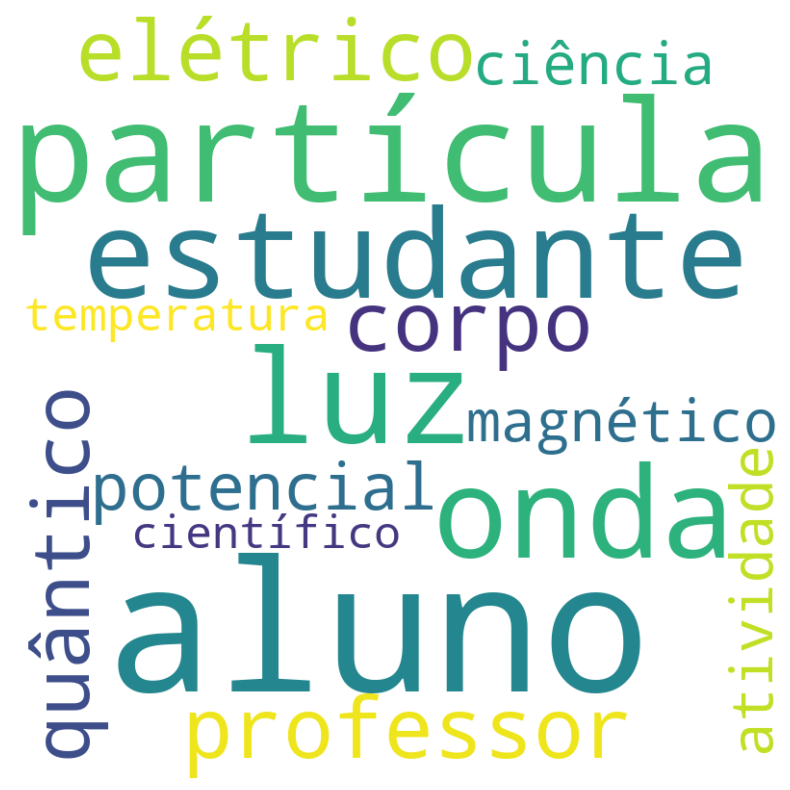

In [116]:
plot_wordcloud(dicionario, filename='wc_dicionario_filtro.png')

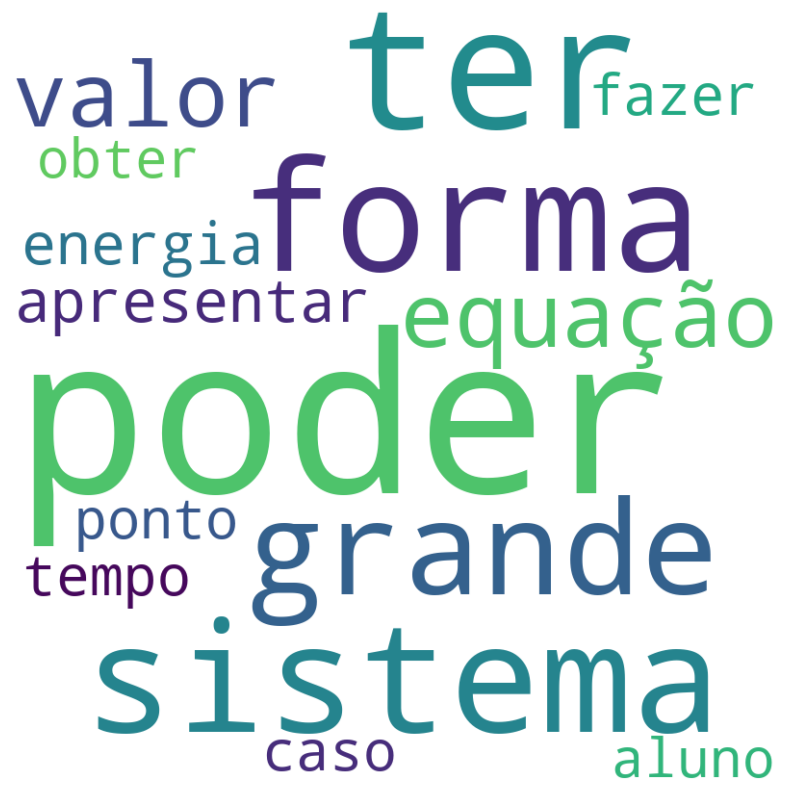

In [117]:
plot_wordcloud(dicionario_sem_filtro, filename='wc_dicionario.png')

In [9]:
corpus = create_corpus(dicionario, documentos, use_tfidf=False)

In [10]:
lda = ModelLDA(corpus, dicionario, chunksize=2000, iterations=400, passes=50)

In [57]:
def run_model(lda, k):
    model = lda.run(k)
    df_k = df.copy()
    
    coerencia = calc_coherence(model, documentos, dicionario, corpus, method='c_v')
    valor = coerencia.get_coherence()
    print(f'coerencia: {valor:4f}', end='\n\n')

    topicos = model.get_document_topics(corpus, minimum_probability=0)
    df_k['topico'] = [max(topic, key=lambda x: x[1])[0] for topic in topicos]

    dicts_list = []
    for topics in topicos:
        temp_dict = {}
        for topic, prob in topics:
            temp_dict[f"topico_{topic}"] = prob
        dicts_list.append(temp_dict)

    df_k = pd.concat([df_k, pd.DataFrame(dicts_list)], axis=1)
    print(pd.crosstab(df_k['nova_seção'], df_k['topico']),end='\n\n')

    # metricas de dispersão
    df_topicos = df_k[[col for col in df_k.columns if 'topico_' in col ]]
    df_k['topico_desvpad'] = df_topicos.std(axis=1, ddof=1)
    df_k['topico_entropia'] = -np.sum(df_topicos * np.log(df_topicos), axis=1)
    df_k['topico_HHI'] = np.sum(df_topicos**2, axis=1)
    
    n = 10  # numero de artigos
    m = 15  # numero de palavras por topico
    for i in df_k.topico.value_counts().keys():
        topics = model.show_topic(i, topn=m)
        palavras = ', '.join([elem[0] for elem in topics])
        temp = df_k.sort_values(by=[f'topico_{i}']).tail(n)
        
        print(f'Tópico {i} | {df_k.topico.value_counts()[i]}')
        print('Palavras:')
        print(palavras, end='\n\n')
        print(f'{n} artigos mais relevantes para esse tópico:')
        
        for j, rows in enumerate(temp.iterrows(), start=1):
            idx, row = rows
            print(f'{j} - {row.titulo} ({row.ano})')
        print('-'*100)

    return model, df_k

# K = 12

In [58]:
model, df_12 = run_model(lda, 12)

coerencia: 0.613700

topico                               0    1   2    3   4    5   6   7   8   \
nova_seção                                                                   
SEM CATEGORIA                         0    1   2    1   1    0   1   3   1   
artigos gerais                       51  190  82   24   9  115  58  56  99   
história da física e ciências afins  12    6   8    7   0    5   0  14   2   
outros                                2   15   6   39   5   10   8  13   2   
pesquisa em ensino de física          9    2  11  122  37   18  21   3   1   
produtos e materiais didáticos       25    4  18   41   9   33  47   6   2   
seções especiais                      3   10   8   10  10    4   1   1  10   

topico                               9   10  11  
nova_seção                                       
SEM CATEGORIA                         0   3   3  
artigos gerais                       48  12  63  
história da física e ciências afins   8  79  14  
outros                    

In [59]:
names = ['Ensino',
'Mecânica Quântica',
'Mecânica Clássica',
'História da Ciência',
'Circuito Elétrico',
'Termodinâmica',
'Física dos Materiais',
'Física Moderna',
'Ótica',
'Eletromagnetismo',
'Astronomia',
'Metodologia']

dici = { names[i]:k for i, k in enumerate(df_12.topico.value_counts().keys())}

/tmp/ipykernel_76932/2761368343.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,35,5), fontsize=14)


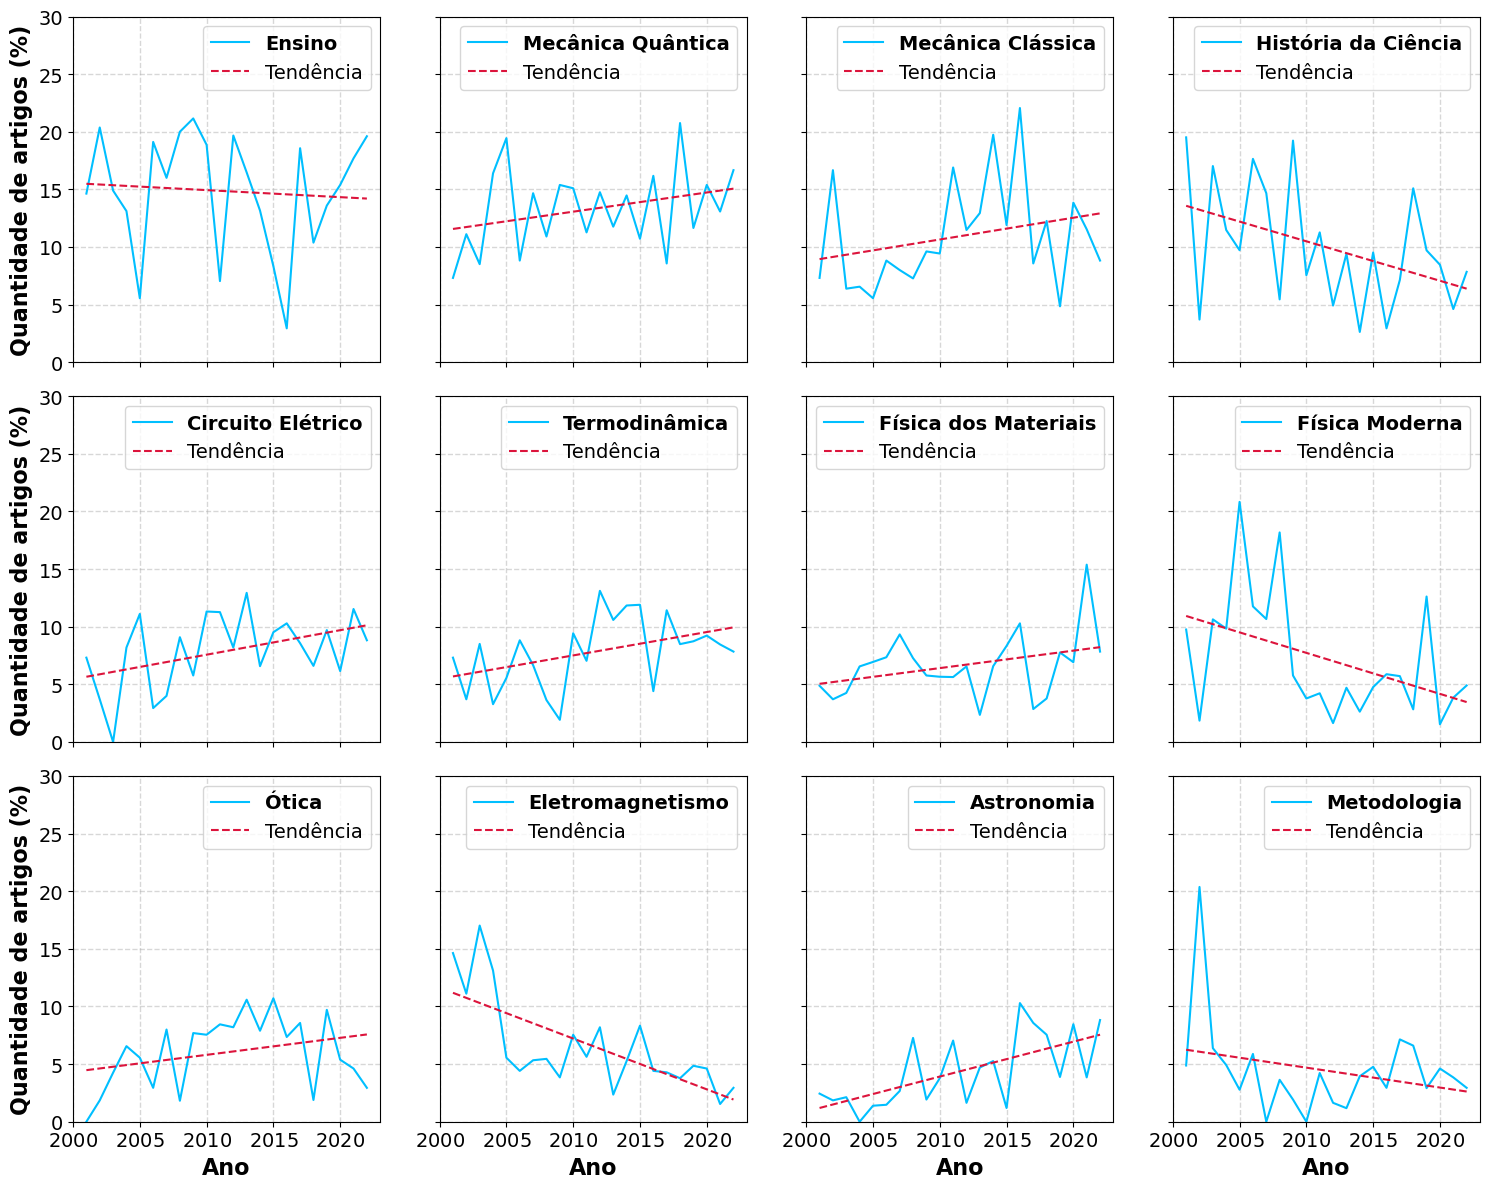

In [101]:
df_agrupado = df_12.pivot_table(index='ano', columns='topico', aggfunc='size', fill_value=0)

# Calcular a soma total de frequências por ano
df_agrupado['frequencia_total'] = df_agrupado.sum(axis=1)

# Calcular a porcentagem do tópico em relação ao total no ano
df_porcentagem = df_agrupado.divide(df_agrupado['frequencia_total'], axis=0) * 100

# Se desejar, reorganize as colunas
df_porcentagem = df_porcentagem[['frequencia_total'] + list(df_agrupado.columns.drop('frequencia_total'))]

# Criar subplot 3x4
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

# Iterar sobre os tópicos e plotar cada um em um subplot separado
for i, topico in enumerate(dici):
    id_ = dici[topico]
    dados_topico = df_porcentagem[id_]
    x, y = dados_topico.keys(), dados_topico.values
    fit = np.polyfit(x, y, 1)
    
    ax = axs[i // 4, i % 4]  # Determinar a posição do subplot
    ax.plot(x, y, label=f'{topico}', c='deepskyblue')
    ax.plot(x, fit[0]*x + fit[1], ls='--', label='Tendência', c='crimson')
    # ax.set_title(f'Tópico {topico+1}', weight='bold', size=15)
    ax.set_ylim([0, 30])
    ax.set_xlim([2000, 2023])
    ax.tick_params(axis='x', labelsize=14) 
    
    ax.grid(alpha=0.5, ls='--', lw=1)
    legenda = ax.legend(fontsize=14)
    legenda.get_texts()[0].set_fontweight('bold')
    
    if i >= 8:
        ax.set_xlabel('Ano', weight='bold', size=16)
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
        
    if i % 4 == 0:
        ax.set_ylabel('Quantidade de artigos (%)', weight='bold', size=16)
        ax.set_yticklabels(range(0,35,5), fontsize=14)
    else:
        ax.yaxis.set_tick_params(labelleft=False)
        
    
    
# Ajustar espaçamento entre subplots
plt.tight_layout()
# Exibir o gráfico
plt.show()
fig.savefig('plots/tópicosporano.png', dpi=300, bbox_inches='tight')

In [61]:
# calcular o desvio padrao dos topicos dos artigos
df_12.head()

,titulo,ano,seção,nova_seção,doi_id,texto_html,topico,topico_0,topico_1,topico_2,...,topico_5,topico_6,topico_7,topico_8,topico_9,topico_10,topico_11,topico_desvpad,topico_entropia,topico_HHI
0,Discussão dos Conceitos de Massa Inercial e Ma...,2001,notas e discussões,outros,10.1590/S1806-11172001000300013,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d...",11,0.000079,0.000119,0.000105,...,0.241664,0.000076,0.000069,0.000087,0.000060,0.369842,0.371437,0.150781,1.152907,0.333416
1,A influência do fator de vibração térmica na d...,2001,SEM CATEGORIA,SEM CATEGORIA,10.1590/S1806-11172001000200012,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d...",2,0.150811,0.047811,0.566119,...,0.000147,0.000108,0.000098,0.166336,0.000084,0.000158,0.000129,0.163618,1.242094,0.377813
2,Perfil de velocidade para o escoamento de flui...,2001,SEM CATEGORIA,SEM CATEGORIA,10.1590/S1806-11172001000200010,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d...",8,0.000098,0.121433,0.000130,...,0.322359,0.051238,0.000085,0.492309,0.000073,0.000138,0.000113,0.159676,1.181937,0.363795
3,Uso da Pesquisa em Ensino de Física na prática...,2001,editorial,outros,10.1590/S1806-11172001000300001,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d...",3,0.000264,0.000397,0.000350,...,0.000346,0.000254,0.000230,0.000290,0.000198,0.000374,0.000305,0.287646,0.029743,0.993474
4,"Introdução à supercondutividade, suas aplicaçõ...",2001,artigos gerais,artigos gerais,None,"<!DOCTYPE html>\n<div class=""articleTxt"">\n <d...",7,0.000045,0.000068,0.241157,...,0.000059,0.053110,0.497313,0.006175,0.000034,0.201864,0.000052,0.155432,1.204443,0.349085


In [91]:
df_12[['topico_desvpad', 'topico_entropia', 'topico_HHI']].describe().T

,count,mean,std,min,25%,50%,75%,max
topico_desvpad,1664.0,0.184469,0.045391,0.020200,0.149533,0.178156,0.213423,0.288559
topico_entropia,1664.0,0.998839,0.398574,0.004144,0.742889,1.042840,1.299736,2.458234
topico_HHI,1664.0,0.480301,0.194984,0.087822,0.329295,0.432467,0.584375,0.999265


<AxesSubplot:>

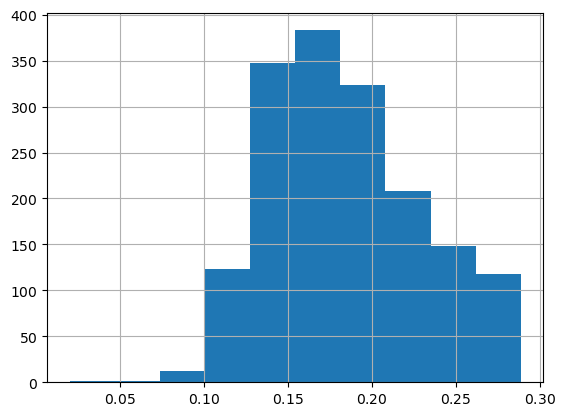

In [63]:
df_12['topico_desvpad'].hist()

<AxesSubplot:>

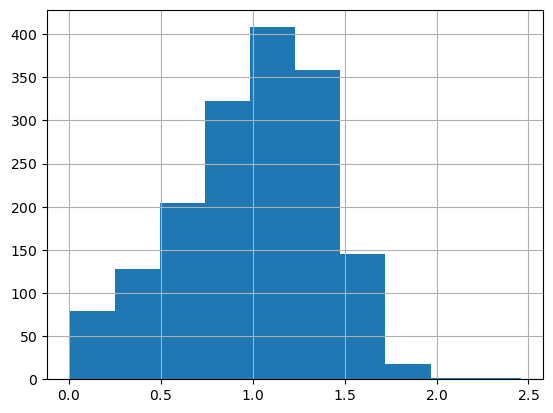

In [64]:
df_12['topico_entropia'].hist()

<AxesSubplot:>

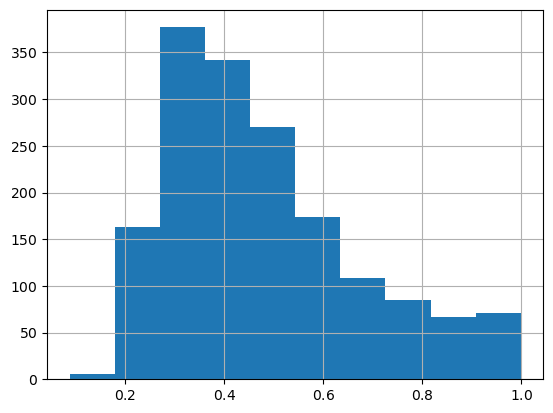

In [65]:
df_12['topico_HHI'].hist()

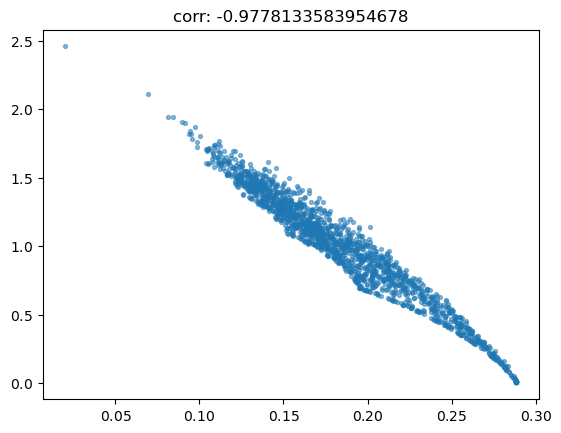

In [88]:
plt.scatter(df_12['topico_desvpad'], df_12['topico_entropia'], s=8, alpha=0.5)
plt.title(f"corr: {df_12['topico_desvpad'].corr(df_12['topico_entropia'])}")
plt.show()

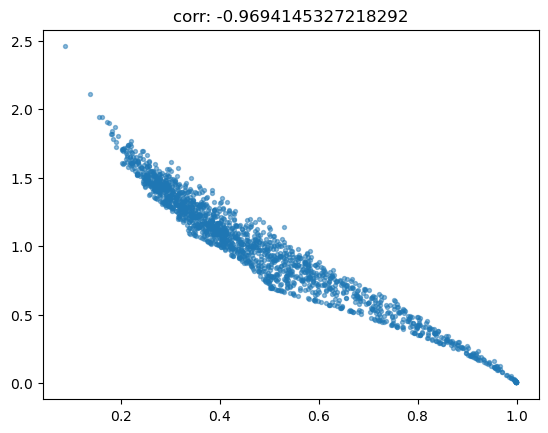

In [89]:
plt.scatter(df_12['topico_HHI'], df_12['topico_entropia'], s= 8, alpha=0.5)
plt.title(f"corr: {df_12['topico_HHI'].corr(df_12['topico_entropia'])}")
plt.show()

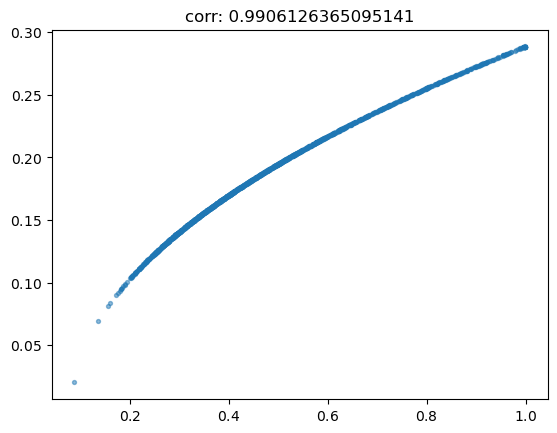

In [90]:
plt.scatter(df_12['topico_HHI'], df_12['topico_desvpad'], s=8, alpha=0.5)
plt.title(f"corr: {df_12['topico_HHI'].corr(df_12['topico_desvpad'])}")
plt.show()

# K = 9

In [45]:
model, df_9 = run_model(lda, 9)

coerencia: 0.609315

topico                                0    1   2   3    4    5   6   7    8
nova_seção                                                                 
SEM CATEGORIA                         0    3   3   2    1    2   1   2    2
artigos gerais                       51  229  96  27   11  161  65  59  108
história da física e ciências afins  14    9   8  57    0    5  29  21   12
outros                                3   20   5  67    8   20   8  13    5
pesquisa em ensino de física         11    2  10  47  115   38   7   4    2
produtos e materiais didáticos       24    7  20  14   37   80  10   9    1
seções especiais                      4   17   7  25   12    7   8   1   18

Tópico 5 | 313
Palavras:
ar, gráfico, pêndulo, corpo, tensão, coeficiente, frequência, sinal, aceleração, atrito, comprimento, cm, circuito, oscilação, sensor

10 artigos mais relevantes para esse tópico:
1 - Determinação do módulo de Young em sólidos a partir da medida da velocidade do som pe

# K = 6

In [46]:
model, df_6 = run_model(lda, 6)

coerencia: 0.611839

topico                                0    1    2   3    4    5
nova_seção                                                     
SEM CATEGORIA                         2    6    3   1    1    3
artigos gerais                       84  331  143  31   10  208
história da física e ciências afins  51   18   19  55    2   10
outros                               10   37   12  65    6   19
pesquisa em ensino de física         14    4   12  60  105   41
produtos e materiais didáticos       29    7   25  14   38   89
seções especiais                     11   22   20  28   12    6

Tópico 1 | 425
Palavras:
partícula, quântico, potencial, carga, clássico, onda, vetor, operador, coordenada, mecânico, transformação, elétrico, parâmetro, matriz, simetria

10 artigos mais relevantes para esse tópico:
1 - O oscilador harmônico singular revisitado (2013)
2 - Solução do átomo de hidrogênio usando Supersimetria (2019)
3 - Geração de soluções exatas em Relatividade Geral através do Méto

# K = 15

In [47]:
model, df_15 = run_model(lda, 15)

coerencia: 0.628288

topico                               0   1   2   3   4   5   6   7   8   9   \
nova_seção                                                                    
SEM CATEGORIA                         0   3   2   3   2   0   1   1   0   0   
artigos gerais                       49  98  64  18  71  18  48  33  66  34   
história da física e ciências afins  11   4   6  60   0   1   0  17   3  12   
outros                                2  14   7  43   7   1   8   4   0   1   
pesquisa em ensino de física         10   2  10  10   7   1  16   2   1   3   
produtos e materiais didáticos       26   3  15   7   5  10  38   5   0   9   
seções especiais                      4   3   9  25   1   4   0   1  13   2   

topico                               10   11  12  13   14  
nova_seção                                                 
SEM CATEGORIA                         1    2   0   0    1  
artigos gerais                       24  118  86  57   23  
história da física e ciênci